In [48]:
pip install pytorch-lightning datasets tensorboard

In [49]:
# constants.py

In [51]:
from pathlib import Path
from datasets import load_dataset


def ensure_dir(path: Path) -> Path:
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
    if not path.is_dir():
        raise FileExistsError(f"Specified path {path} is not a dir")
    return path


ROOT = Path(os.getcwd())
DATA_PATH = "Matthijs/snacks"
DATA = ensure_dir(ROOT / "data")
TRAIN_DIR = DATA / "train"
VAL_DIR = DATA / "validation"
TEST_DIR = DATA / "test"
LIGHTNING_LOGS = ROOT / "lightning_logs"

LABEL_DICT = {
    "0": "apple",
    "1": "banana",
    "2": "cake",
    "3": "candy",
    "4": "carrot",
    "5": "cookie",
    "6": "doughnut",
    "7": "grape",
    "8": "hot dog",
    "9": "ice cream",
    "10": "juice",
    "11": "muffin",
    "12": "orange",
    "13": "pineapple",
    "14": "popcorn",
    "15": "pretzel",
    "16": "salad",
    "17": "strawberry",
    "18": "waffle",
    "19": "watermelon",
}


In [52]:
ROOT

PosixPath('/content')

In [53]:
LIGHTNING_LOGS

PosixPath('/content/lightning_logs')

In [57]:
# save_image_data.py

In [56]:
from datasets import load_dataset
from pathlib import Path
from tqdm import tqdm


def save_image(data, idx, split):
    image_data = data["image"]
    image_label = data["label"]
    image_path = DATA / split / f"image_{idx}_label_{image_label}.png"

    image_data.save(image_path)


  train_dataset = load_dataset(DATA_PATH, split="train")
  val_dataset = load_dataset(DATA_PATH, split="validation")
  test_dataset = load_dataset(DATA_PATH, split="test")

  if not TRAIN_DIR.exists():
      TRAIN_DIR.mkdir(parents=True, exist_ok=True)

      for idx, data in enumerate(train_dataset):
          save_image(data, idx, split="train")
      print(f"Train images saved at {TRAIN_DIR}")

  if not VAL_DIR.exists():
      VAL_DIR.mkdir(parents=True, exist_ok=True)
      for idx, data in enumerate(val_dataset):
          save_image(data, idx, split="validation")
      print(f"Validation images saved at {VAL_DIR}")

  if not TEST_DIR.exists():
      TEST_DIR.mkdir(parents=True, exist_ok=True)
      for idx, data in enumerate(test_dataset):
          save_image(data, idx, split="test")
      print(f"Test images saved at {TEST_DIR}")

Train images saved at /content/data/train
Validation images saved at /content/data/validation
Test images saved at /content/data/test


In [ ]:
# configs.py

In [47]:
import json
import pickle

from typing import Literal
from pathlib import Path


class Config:
    def __init__(
        self,
        backbone: Literal["resnext", "efficientnet", "mobilenet", "wide_resnet"],
        augment: bool,
        epochs: int,
        lr: float,
        wd: float,
    ) -> None:
        """Creates a config object that can be passed around across
        the project as a lightweight to carry necessary information.

        Params:
        -------
        backbone: Literal['resnext', 'efficientnet', 'mobilenet', 'wide_resnet']

        augment: bool

        epochs: int

        lr: float

        wd: float

        Returns:
        --------
        None"""
        self.backbone = backbone
        self.augment = augment
        self.epochs = epochs
        self.lr = lr
        self.wd = wd

    @classmethod
    def build(cls, config_path: Path):
        """Builds a config object given a config path."""
        with open(config_path, "r") as f:
            config_dict = json.load(f)
        config = cls(**config_dict)
        return config

    def to_json(self, log_version_dir):
        """Converts the config dict and stores it in a json format
        (as a record incase we want to re-run the model or load an
        existing model)."""
        out_dir = log_version_dir / "configs.json"
        with open(out_dir, "w") as handle:
            config_dict = {**self.__dict__}
            new_dict = {}
            for key, dict_value in config_dict.items():
                value = dict_value
                new_dict[key] = value
            json.dump(new_dict, handle, default=str, indent=2)

    def to_pickle(self, log_version_dir):
        """Converts the config dict and stores it in a pickle format."""
        out_dir = log_version_dir / "configs.pickle"
        with open(out_dir, "wb") as handle:
            pickle.dump(self, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def save(self, log_version_dir):
        """Save the config dict in json and pickle format."""
        self.to_json(log_version_dir=log_version_dir)
        self.to_pickle(log_version_dir=log_version_dir)

    def __repr__(self) -> str:
        """Readable representation of config dict."""
        fmt = (
            f"{self.__class__.__name__}(\n"
            f"\t         Backbone: {self.backbone}\n"
            f"\t          Augment: {self.augment}\n"
            f"\t    Learning Rate: {self.lr}\n"
            f"\t     Weight Decay: {self.wd}\n"
            ")"
        )
        return fmt


In [9]:
# loaders.py

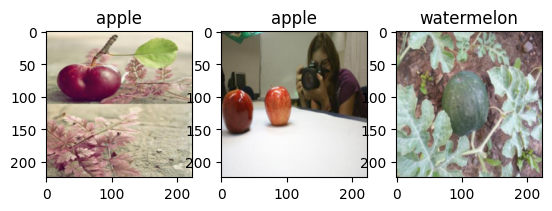

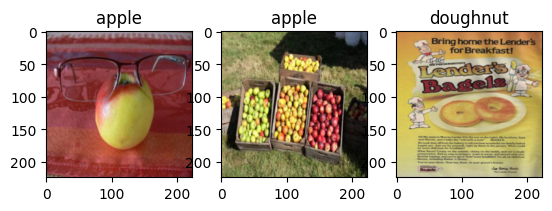

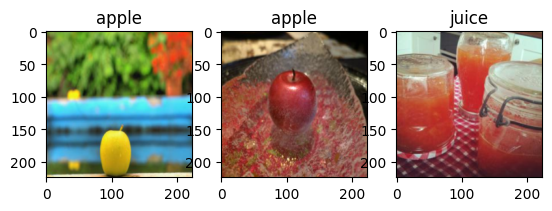

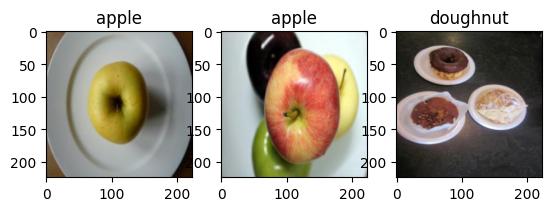

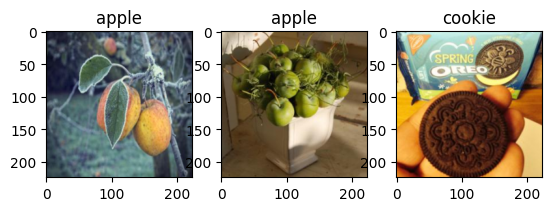

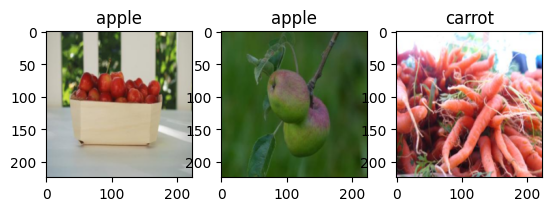

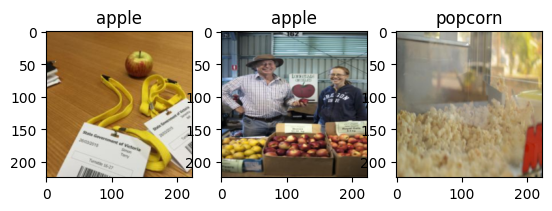

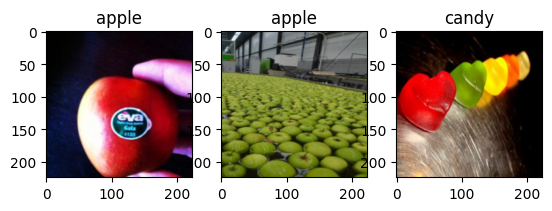

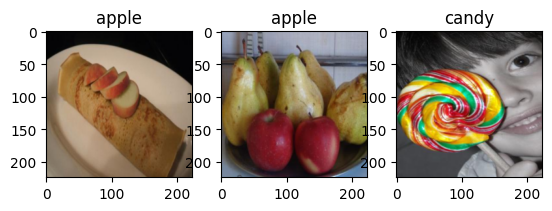

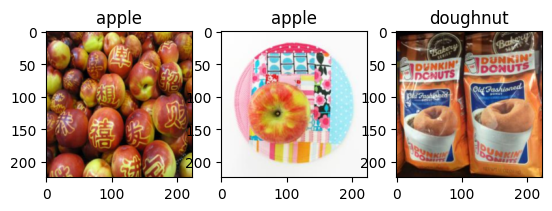

In [28]:
from typing import Literal

import random

import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision import transforms
from datasets import load_dataset


class SnacksDataset(Dataset):
    def __init__(
        self,
        config: Config,
        split: Literal["train", "validation"] = "train",
    ) -> None:
        """Build a PyTorch dataset (following a Huggingface DATAPATH -
        stored in `constants.py`) using a specified config and a desired split.

        Params:
        -------
        config: Config

        split: Literal['train', 'validation'] = 'train'

        Returns:
        --------
        None"""
        self.config = config
        self.dataset = load_dataset(DATA_PATH, split=split)

        if not self.config.augment and split == "train":
            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.RandomRotation(degrees=15),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
                ]
            )

        self.labels = [item["label"] for item in self.dataset]
        self.label_to_indices = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)

    def __len__(self):
        """Returns the length of dataset"""
        return len(self.labels)

    def __getitem__(self, idx: int):
        """Returns an anchor image, positive image (one with the same label as anchor image)
        and a negative image (one with a different index from anchor) along with
        their respective labels.

        Params:
        -------
        idx: int

        Returns:
        --------
        anchor_img: Tensor

        positive_img: Tensor

        negative_img: Tensor

        anchor_label: int

        positive_label: int

        negative_label: int"""
        anchor_img = self.transform(self.dataset[idx]["image"])
        anchor_label = self.dataset[idx]["label"]

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = random.choice(self.label_to_indices[anchor_label])

        negative_label = random.choice(list(set(self.labels) - {anchor_label}))
        negative_idx = random.choice(self.label_to_indices[negative_label])

        positive_img = self.transform(self.dataset[positive_idx]["image"])
        negative_img = self.transform(self.dataset[negative_idx]["image"])

        positive_label = self.dataset[positive_idx]["label"]
        negative_label = self.dataset[negative_idx]["label"]

        return (
            anchor_img,
            positive_img,
            negative_img,
            anchor_label,
            positive_label,
            negative_label,
        )


class TestDataset(Dataset):
    def __init__(self):
        """Build a PyTorch test dataset following a test split."""
        self.dataset = load_dataset(DATA_PATH, split="test")

        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ]
        )

    def __len__(self):
        """Returns the length of dataset."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """Returns an image and corresponding label.
        Params:
        -------
        idx: int

        Returns:
        --------
        img: Tensor

        label: int"""
        img = self.transform(self.dataset[idx]["image"])
        label = self.dataset[idx]["label"]
        return img, label


if __name__ == "__main__":
    # dummy test (works as expected)
    config = Config(
        backbone="resnext",
        augment=False,
        epochs=1,
        lr=1e-4,
        wd=1e-2,
    )
    ds = SnacksDataset(config=config, split="train")

    for i in range(10):
        a_img, p_img, n_img, a_label, p_label, n_label = ds[i]
        fig, ax = plt.subplots(nrows=1, ncols=3)
        ax[0].imshow(a_img.permute(1, 2, 0))
        ax[1].imshow(p_img.permute(1, 2, 0))
        ax[2].imshow(n_img.permute(1, 2, 0))
        ax[0].set_title(LABEL_DICT[str(a_label)])
        ax[1].set_title(LABEL_DICT[str(p_label)])
        ax[2].set_title(LABEL_DICT[str(n_label)])
        plt.show()


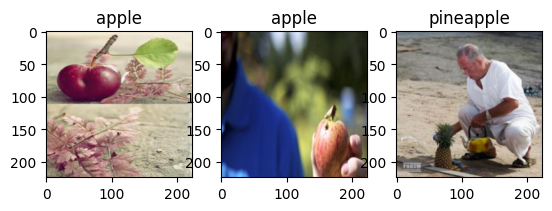

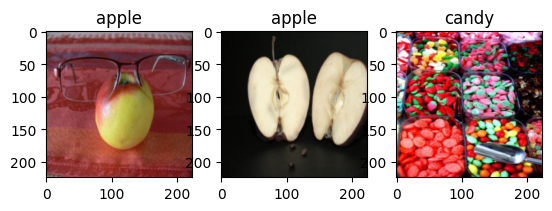

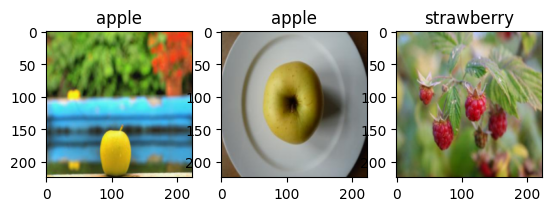

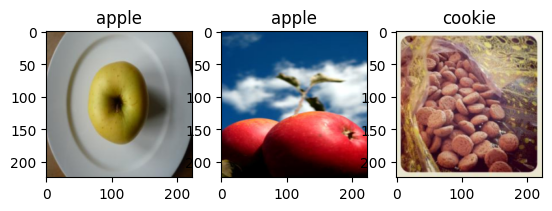

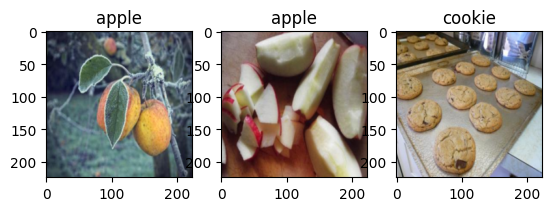

In [29]:
# dummy test (works as expected)
config = Config(
    backbone="resnext",
    augment=False,
    epochs=1,
    lr=1e-4,
    wd=1e-2,
)
ds = SnacksDataset(config=config, split="train")

for i in range(5):
    a_img, p_img, n_img, a_label, p_label, n_label = ds[i]
    fig, ax = plt.subplots(nrows=1, ncols=3)
    ax[0].imshow(a_img.permute(1, 2, 0))
    ax[1].imshow(p_img.permute(1, 2, 0))
    ax[2].imshow(n_img.permute(1, 2, 0))
    ax[0].set_title(LABEL_DICT[str(a_label)])
    ax[1].set_title(LABEL_DICT[str(p_label)])
    ax[2].set_title(LABEL_DICT[str(n_label)])
    plt.show()

In [ ]:
# model.py

In [43]:
from typing import List, Tuple

import torch
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import Tensor

class TripletLoss(nn.Module):
    def __init__(self, alpha: float = 1.0):
        """Computes loss on the basis of embeddings from
        anchor, positive and negative image.

        Params:
        -------
        alpha: float = 1.0

        Returns:
        --------
        None"""
        super().__init__()
        self.margin = alpha

    def forward(
        self,
        anchor: Tensor,
        positive: Tensor,
        negative: Tensor,
    ) -> Tensor:
        """Uses Euclidean distance to measures distances between
        embeddings from anchor, positive and negative image and
        returns a mean from the losses tensor.

        Params:
        -------
        anchor: Tensor

        positive: Tensor

        negative: Tensor

        Returns:
        --------
        losses.mean(): Tensor"""
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


class ImageEncoder(pl.LightningModule):
    def __init__(self, pretrained=True, backbone: str = "resnext") -> None:
        """Initialize a pre-trained encoder model for images, which could
        also be thought of as backbone of the structure

        Params:
        -------
        pretrained: bool

        backbone: str = resnext

        Returns:
        --------
        None"""
        super().__init__()

        # Initialize the backbone with a pre-trained model
        if backbone == "resnext":
            self.backbone = models.resnext50_32x4d(pretrained=pretrained)
        elif backbone == "efficientnet":
            self.backbone = models.efficientnet_v2_s(pretrained=pretrained)
        elif backbone == "mobilenet":
            self.backbone = models.mobilenet_v3_small(pretrained=pretrained)
        elif backbone == "wide_resnet":
            self.backbone = models.wide_resnet50_2(pretrained=pretrained)
        else:
            raise ValueError(f"{self.backbone} backbone is not implemented.")
        in_features = int(list(self.backbone.children())[-1].in_features)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Freeze the early layers of the backbone
        for param in list(self.backbone.parameters())[:-27]:
            param.requires_grad = False

        # Define the additional encoding layers
        self.encoding_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            self.L2Normalization(),
        )

    def forward(self, x: Tensor) -> Tensor:
        """Returns embeddings of the image.

        Params:
        -------
        x: Tensor

        Returns:
        --------
        x: Tensor"""
        x = self.backbone(x)
        x = self.encoding_layers(x)
        return x

    class L2Normalization(nn.Module):
        def forward(self, x):
            return F.normalize(x, p=2, dim=1)


class SiameseNetwork(pl.LightningModule):
    def __init__(self, config: Config):
        """Buils a siamese net using PyTorch Lightning module and
        trains alongside triplet loss.

        Params:
        -------
        config: Config

        Returns:
        --------
        None"""
        super().__init__()
        self.config = config
        self.encoder = ImageEncoder()
        self.criterion = TripletLoss()
        self.test_dataset_cache = {}

    def forward(self, anchor, positive, negative):
        """Returns embeddings for anchor, positive and negative image.

        Params:
        -------
        anchor: Tensor

        postive: Tensor

        negative: Tensor"""
        encoded_anchor = self.encoder(anchor)
        encoded_positive = self.encoder(positive)
        encoded_negative = self.encoder(negative)
        return encoded_anchor, encoded_positive, encoded_negative

    def find_similar_images(
        self,
        input_image: Tensor,
        test_dataset: TestDataset,
        top_k: int = 5,
    ) -> Tuple[List[int], List[float]]:
        """Computes distances among each images in the dataset to find similarities and
        returns the images that lie closest to the input image.

        Params:
        -------
        input_image: Tensor

        test_dataset: TestDataset

        top_k: int = 5

        Returns:
        --------
        top_k_indices: List[int]

        top_k_similarities: List[float]"""
        self.eval()  # Set the network in evaluation mode

        # Creating a hash key for the test dataset
        test_dataset_key = hash(
            tuple(hash(img.cpu().numpy().tobytes()) for img, _ in test_dataset)
        )

        cache_file_path = Path(ROOT / f"cache_{test_dataset_key}.pkl")

        if cache_file_path.exists():
            with open(cache_file_path, "rb") as f:
                self.test_dataset_cache = pickle.load(f)
        else:
            # If the test dataset features are not in the cache, compute and store them
            if test_dataset_key not in self.test_dataset_cache:
                with torch.no_grad():
                    self.test_dataset_cache[test_dataset_key] = [
                        self.encoder(img.unsqueeze(0).to(self.device))
                        for img, _ in test_dataset
                    ]

            with open(cache_file_path, "wb") as f:
                pickle.dump(self.test_dataset_cache, f)

        with torch.no_grad():  # Disable gradient computation
            input_image = input_image.unsqueeze(0).to(self.device)
            input_image_feature = self.encoder(input_image)

            # Retrieve the cached test dataset features
            test_features = self.test_dataset_cache[test_dataset_key]

            # Compute the similarities between the input image and the test dataset
            similarities = [
                F.cosine_similarity(input_image_feature, test_feature, dim=-1).item()
                for test_feature in test_features
            ]

            # Find the top k most similar images
            top_k_indices = sorted(
                range(len(similarities)), key=lambda i: similarities[i], reverse=True
            )[1 : top_k + 1]
            top_k_similarities = [similarities[i] for i in top_k_indices]

        return top_k_indices, top_k_similarities

    def training_step(
        self,
        batch: Tuple[Tensor, Tensor, Tensor, int, int, int],
        batch_idx,
    ) -> Tensor:
        anchor, positive, negative, _, _, _ = batch
        output_anchor, output_positive, output_negative = self(
            anchor, positive, negative
        )
        loss = self.criterion(output_anchor, output_positive, output_negative)
        self.log("train/triplet", loss, prog_bar=True, on_step=True)
        return loss

    def validation_step(
        self,
        batch: Tuple[Tensor, Tensor, Tensor, int, int, int],
        batch_idx,
    ) -> Tensor:
        anchor, positive, negative, _, _, _ = batch
        output_anchor, output_positive, output_negative = self(
            anchor, positive, negative
        )
        loss = self.criterion(output_anchor, output_positive, output_negative)
        self.log("val/triplet", loss, prog_bar=True, on_step=True)
        return loss

    def configure_optimizers(
        self,
    ) -> Tuple[List[torch.optim.AdamW], List[CosineAnnealingLR]]:
        opt = torch.optim.AdamW(self.parameters(), lr=self.config.lr)
        sched = CosineAnnealingLR(optimizer=opt, T_max=self.config.epochs)
        return [opt], [sched]

In [13]:
# train.py

In [30]:
from typing import Tuple

import argparse
from pathlib import Path

import pytorch_lightning as pl

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


def get_loaders(config: Config) -> Tuple[DataLoader, DataLoader, TestDataset]:
    train_dataset = SnacksDataset(config=config, split="train")
    val_dataset = SnacksDataset(config=config, split="validation")
    test_dataset = TestDataset()

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    return train_loader, val_loader, test_dataset


def train_siamese(
    config: Config,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> None:
    """The below method trains and stores a siamese network
    along with a specified config.

    Params:
    -------
    config: Config

    train_loader: DataLoader

    val_loader: DataLoader

    Returns:
    --------
    None"""
    model = SiameseNetwork(config=config)

    model_checkpoint = ModelCheckpoint(
        filename="{epoch}_{val_loss:1.3f}",
        monitor="val/triplet",
        save_last=True,
        save_top_k=1,
        mode="min",
        auto_insert_metric_name=True,
        save_weights_only=False,
        every_n_epochs=1,
    )

    early_stopping = EarlyStopping(
        monitor="val/triplet",
        check_finite=True,
        patience=30,
        verbose=False,
        mode="min",
    )

    trainer = pl.Trainer(
        max_epochs=config.epochs, callbacks=[model_checkpoint, early_stopping]
    )
    if trainer.log_dir is None:
        raise ValueError("No logging dir was found.")
    log_version_dir = Path(trainer.log_dir)

    if not log_version_dir.exists():
        log_version_dir.mkdir(parents=True, exist_ok=True)

    trainer.fit(model, train_loader, val_loader)
    print("Model trained.")

    config.save(log_version_dir)
    print(f"Configs saved at {log_version_dir}")

In [17]:
# run.py

In [33]:
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Ideally we want to using a 4x2 or 6x2 grid for lr and wd
# lr = [1e-1, 1e-2, 1e-3, 1e-4]
# wd = [1e-2, 1e-4]
# and check with different kinds of backbone - (image encoder)
# backbone = ["resnext", "efficientnet", "mobilenet", "wide_resnet"]

grid_dicts = list(
    ParameterGrid(
        dict(
            backbone=[
                "wide_resnet",
            ],
            augment=[False, True],
            lr=[3e-4],
            wd=[1e-2],
            epochs=[30],
        )
    )
)

configs = [Config(**grid_dict) for grid_dict in grid_dicts]
pbar = tqdm(configs)
for config in pbar:
    print(config)
    train_loader, val_loader, test_dataset = get_loaders(config=config)

    train_siamese(
        config=config,
        train_loader=train_loader,
        val_loader=val_loader,
    )



  0%|          | 0/2 [00:00<?, ?it/s]

Config(
	         Backbone: wide_resnet
	          Augment: False
	    Learning Rate: 0.0003
	     Weight Decay: 0.01
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | ImageEncoder | 24.2 M
1 | criterion | TripletLoss  | 0     
-------------------------------------------
14.7 M    Trainable params
9.5 M     Non-trainable params
24.2 M    Total params
96.779    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.

 50%|█████     | 1/2 [1:16:40<1:16:40, 4600.31s/it]

Model trained.
Configs saved at /content/lightning_logs/version_6
Config(
	         Backbone: wide_resnet
	          Augment: True
	    Learning Rate: 0.0003
	     Weight Decay: 0.01
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | ImageEncoder | 24.2 M
1 | criterion | TripletLoss  | 0     
-------------------------------------------
14.7 M    Trainable params
9.5 M     Non-trainable params
24.2 M    Total params
96.779    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.

100%|██████████| 2/2 [2:38:18<00:00, 4749.14s/it]

Model trained.
Configs saved at /content/lightning_logs/version_7


In [20]:
# evaluate.py

In [34]:
from typing import List, Tuple
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor


def get_config(version_number: int):
    """Builds a config object using the version number, we can
    eye ball the best version by montoring the lightning logs.

    Params:
    -------
    version_number: int

    Returns:
    --------
    config: Config"""
    config_path = Path(LIGHTNING_LOGS / f"version_{version_number}/configs.json")
    return Config.build(config_path=config_path)


def best_rect(m: int) -> Tuple[int, int]:
    """Returns n_rows and n_cols giving the number of images we
    want to plot. (super handy)

    Params:
    -------
    m: int

    Returns:
    --------
    prod: Tuple[int, int]"""
    low = int(np.floor(np.sqrt(m)))
    high = int(np.ceil(np.sqrt(m)))
    prods = [(low, low), (low, low + 1), (high, high), (high, high + 1)]
    for i, prod in enumerate(prods):
        if prod[0] * prod[1] >= m:
            return prod
    raise ValueError("Not possible!")


def img_similarity_search(
    config: Config,
    version_number: int,
    input_img: Tensor,
    label: int,
    dataset: TestDataset,
    num_show_similar: int = 5,
):
    """Extracts and plots 'n' relevant images from a dataset where
    n is given by num_show_similar, it also takes a version number
    parameter specifying which trained model to pick.

    It would be ideal if we could pass num_show_similar a value such
    that we could display the images as a grid to avoid any empty blocks
    E.g. num_show_similar = 5
    total_imgs = (num_show_similar + input_img) = (5 + 1) = 6
    so we can get a 2 x 3 grid

    similarly, if num_show_similar = 8
    then, we can get a 3 x 3 grid

    Params:
    -------
    config: Config

    version_number: int

    dataset: TestDataset

    num_show_similar: int

    Returns:
    --------
    None"""
    trained_model = SiameseNetwork.load_from_checkpoint(
        Path(LIGHTNING_LOGS / f"version_{version_number}/checkpoints/last.ckpt"),
        config=config,
    )

    top_k_similar_images, similarity_scores = trained_model.find_similar_images(
        input_img, dataset, top_k=num_show_similar
    )
    plot_similar_images(
        input_img, label, dataset, top_k_similar_images, similarity_scores
    )


def plot_similar_images(
    input_img: Tensor,
    label: int,
    test_dataset: TestDataset,
    similar_img_indices: List[int],
    similarity_scores: List[float],
) -> None:
    """Plotting function given an input_image, dataset, similar image indices
    and similarity scores.

    Params:
    -------
    input_image: Tensor

    test_dataset: TestDataset

    similarity_image_indices: List[int]

    similarity_scores: List[float]

    Returns:
    --------
    None"""
    n_rows, n_cols = best_rect(len(similar_img_indices) + 1)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))
    axes = axes.flatten()
    # Plot the input image
    axes[0].imshow(input_img.permute(1, 2, 0))
    axes[0].set_title(f"Input Image: {label} ({LABEL_DICT[str(label)]})")
    axes[0].axis("off")

    # Plot the similar images
    for i, idx in enumerate(similar_img_indices):
        image, label = test_dataset[idx]  # Extract image and label
        axes[i + 1].imshow(image.permute(1, 2, 0))  # Use the image part of the tuple
        axes[i + 1].set_title(
            f"Similarity Score: {similarity_scores[i]:.4f}\nLabel: {label}"
        )
        axes[i + 1].axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()


In [37]:
VERSION_NUMBER = 7

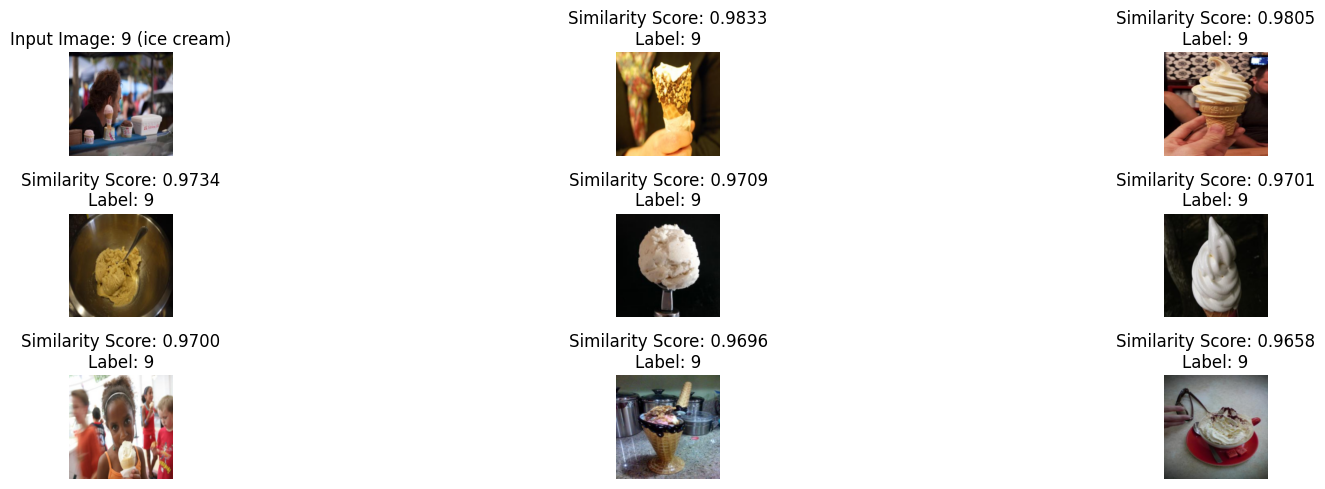

In [46]:
# dummy test
dataset = TestDataset()
config = get_config(version_number=VERSION_NUMBER)

# instead of this we can pass any random image as well
num_images = len(dataset)
idx = int(np.random.choice(num_images, 1)[0])
img, label = dataset[idx]

img_similarity_search(
    config=config,
    version_number=VERSION_NUMBER,
    input_img=img,
    label=label,
    dataset=dataset,
    num_show_similar=8,
)